In [1]:
#%tensorflow_version 1.x

In [5]:
# importing the required libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(r'../../../codes/python/modules')

%load_ext autoreload
%autoreload 2

import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
df_train = pd.read_csv('./data/train_XnW6LSF.csv')
df_test = pd.read_csv('./data/test_FewQE9B.csv')

df = pd.concat([df_train.assign(source = 'train'), df_test.assign(source = 'test')])

In [8]:
# looking at the first five rows of the dataset
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


In [9]:
# shape of the data
df.shape

(14204, 13)

In [10]:
# data types of the variables
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
source                        object
dtype: object

# Pre-processing Steps

<ol>1. Cleaning data (ipek)</ol>
<ol>2. Filling the missing values</ol>
<ol>3. Feature Engineering</ol>
<ol>4. Converting categories to numbers</ol>

## 1. Cleaning Data

Check categorical variables: `Item_Fat_Content, Item_Type, Outlet_Size, Outlet_Location_Type, Outlet_Type`


In [11]:
# Filter categorical variables
cat_cols = [x for x in df.dtypes.index if df.dtypes[x] == 'object']

# Exclude ID cols and source:
cat_cols = [x for x in cat_cols if x not in ['Item_Identifier', 'Outlet_Identifier', 'source']]

# Print frequency of categories
for col in cat_cols:
    print ('\nFrequency of Categories for varible %s'%col)
    print (df[col].value_counts())


Frequency of Categories for varible Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varible Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories for varible Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

Frequency of Categories for varible Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

F

In [12]:
df['Item_Fat_Content'].replace({'LF':'Low Fat', 'reg': 'Regular', 'low fat': 'Low Fat'}, inplace = True)

### Item_Visibility

In our EDA we observe that `Item_Visibility` had minimum value 0. This make no sense, lets consider it as missing value and impute with its mean.

In [13]:
#Determine average visibility of a product
df_tmp = df.pivot_table(values = 'Item_Visibility', index = 'Item_Identifier')

#Impute 0 values with mean visibility of that product
df_miss = df['Item_Visibility'] == 0

print ('Number of 0 values initially: %d'%sum(df_miss))

df.loc[df_miss,'Item_Visibility'] = df.loc[df_miss,'Item_Identifier'].apply(lambda x: df_tmp.at[x, 'Item_Visibility'])

print ('Number of 0 values after modification: {}'.format(sum(df['Item_Visibility'] == 0)))

Number of 0 values initially: 879
Number of 0 values after modification: 0


## 2. Filling the missing values

In [14]:
# checking missing values in the data
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

### Categorical Data: Mode

#### Outlet_Size: Fill missing values with the "mode" by Outlet_Type 

In [15]:
#Import mode function:
from scipy.stats import mode

# Determing the mode for each Outlet_Type
# 1st WAY: outlet_size_mode = df.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]) )
df_tmp = utils.gen_groupby(df, 'Outlet_Size', (lambda x:mode(x).mode[0]), grpby_col_names = 'Outlet_Type')
print ('Mode of Outlet_Size for each Outlet_Type:')
print (df_tmp)

# Get a boolean variable specifying missing Outlet_Size records
df_miss = df['Outlet_Size'].isnull() 

# Impute data and check #missing values before and after imputation to confirm
print ('\nOrignal #missing: %d'% sum(df_miss))
df.loc[df_miss, 'Outlet_Size'] = df.loc[df_miss, 'Outlet_Type'].apply(lambda x: df_tmp.loc[x])
print(sum(df['Outlet_Size'].isnull()))

Mode of Outlet_Size for each Outlet_Type:
                  Outlet_Size
Outlet_Type                  
Grocery Store           Small
Supermarket Type1       Small
Supermarket Type2      Medium
Supermarket Type3      Medium

Orignal #missing: 4016
0


### Continuous Data: Mean

#### Item_Weight

In [16]:
# 1st WAY: df.pivot_table(values='Item_Weight', index='Item_Identifier') # aggfunc='mean'
df_tmp = utils.gen_groupby(df, 'Item_Weight', 'mean', grpby_col_names = 'Item_Identifier')

df_miss = df['Item_Weight'].isnull()

# Impute data and check #missing values before and after imputation to confirm
print ('Orignal #missing: %d'% sum(df_miss))
df.loc[df_miss, 'Item_Weight'] = df.loc[df_miss, 'Item_Identifier'].apply(lambda x: df_tmp.loc[x])
print (sum(df['Item_Weight'].isnull()))

Orignal #missing: 2439
0


In [17]:
# checking missing values after imputation
df.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

## 3. Feature Engineering

In [18]:
#Remember the data is from 2013
df['Outlet_Years'] = 2013 - df['Outlet_Establishment_Year']
df['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

In [19]:
# Getting the first two characters of ID to separate them into different categories
df['Item_Category'] = df['Item_Identifier'].apply(lambda x: x[0:2])

df['Item_Category'] = df['Item_Category'].map({'FD':'Food', 'NC':'Non_Consumable', 'DR':'Drinks'})

df['Item_Category'].value_counts()

Food              10201
Non_Consumable     2686
Drinks             1317
Name: Item_Category, dtype: int64

In [20]:
# Drop the columns which have been converted to different types:
df.drop(['Item_Type', 'Outlet_Establishment_Year'], axis = 1, inplace = True)

## 4. Converting categories to numbers

In [21]:
# converting the categories into numbers using map function
#Item_Fat_Content, Item_Type, Outlet_Identifier, Outlet_Size, Outlet_Location_Type, Outlet_Type
df['Item_Fat_Content'] = df['Item_Fat_Content'].map({'Low Fat': 1, 'Regular': 0})
df['Outlet_Size'] = df['Outlet_Size'].map({'Small': 0, 'Medium': 1, 'High': 2})
df['Outlet_Location_Type'] = df['Outlet_Location_Type'].map({'Tier 1': 0, 'Tier 2': 1, 'Tier 3': 2})

In [22]:
df2 = df.copy()

In [23]:
df2.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Outlet_Years,Item_Category
0,FDA15,9.30,1,0.016047,249.8092,OUT049,1,0,Supermarket Type1,3735.1380,train,14,Food
1,DRC01,5.92,0,0.019278,48.2692,OUT018,1,2,Supermarket Type2,443.4228,train,4,Drinks
2,FDN15,17.50,1,0.016760,141.6180,OUT049,1,0,Supermarket Type1,2097.2700,train,14,Food
3,FDX07,19.20,0,0.017834,182.0950,OUT010,0,2,Grocery Store,732.3800,train,15,Food
4,NCD19,8.93,1,0.009780,53.8614,OUT013,2,2,Supermarket Type1,994.7052,train,26,Non_Consumable


In [24]:
# generate binary values using get_dummies
df = pd.get_dummies(df2, columns=['Outlet_Type', 'Item_Category'])
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Item_Outlet_Sales,source,Outlet_Years,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Category_Drinks,Item_Category_Food,Item_Category_Non_Consumable
0,FDA15,9.30,1,0.016047,249.8092,OUT049,1,0,3735.1380,train,14,0,1,0,0,0,1,0
1,DRC01,5.92,0,0.019278,48.2692,OUT018,1,2,443.4228,train,4,0,0,1,0,1,0,0
2,FDN15,17.50,1,0.016760,141.6180,OUT049,1,0,2097.2700,train,14,0,1,0,0,0,1,0
3,FDX07,19.20,0,0.017834,182.0950,OUT010,0,2,732.3800,train,15,1,0,0,0,0,1,0
4,NCD19,8.93,1,0.009780,53.8614,OUT013,2,2,994.7052,train,26,0,1,0,0,0,0,1


In [25]:
if False:
    # generate binary values using get_dummies
    df = pd.get_dummies(df2, columns=['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Item_Type', 'Outlet_Type'])
    df.head()

## Split the dataset into train and test and save as preprocessed

In [26]:
df_train = df[df.source == 'train'].drop('source', axis = 1)
df_test = df[df.source == 'test'].drop('source', axis = 1)

# saving the pre-processed data
df_train.to_csv('./data/train_preprocessed.csv', index=False)
df_test.to_csv('./data/test_preprocessed.csv', index=False)

# Building a model

<ol>1. Load and check the dataset</ol>
<ol>2. Creating training and validation set</ol>
<ol>3. Models</ol>

## 1. Check the dataset

In [27]:
data = pd.read_csv('./data/train_preprocessed.csv')

In [28]:
# check version on sklearn
print('Version of sklearn:', sklearn.__version__)

Version of sklearn: 0.23.2


In [29]:
# checking missing values
data.isnull().sum()

Item_Identifier                  0
Item_Weight                      0
Item_Fat_Content                 0
Item_Visibility                  0
Item_MRP                         0
Outlet_Identifier                0
Outlet_Size                      0
Outlet_Location_Type             0
Item_Outlet_Sales                0
Outlet_Years                     0
Outlet_Type_Grocery Store        0
Outlet_Type_Supermarket Type1    0
Outlet_Type_Supermarket Type2    0
Outlet_Type_Supermarket Type3    0
Item_Category_Drinks             0
Item_Category_Food               0
Item_Category_Non_Consumable     0
dtype: int64

In [30]:
# checking the data type
data.dtypes

Item_Identifier                   object
Item_Weight                      float64
Item_Fat_Content                   int64
Item_Visibility                  float64
Item_MRP                         float64
Outlet_Identifier                 object
Outlet_Size                        int64
Outlet_Location_Type               int64
Item_Outlet_Sales                float64
Outlet_Years                       int64
Outlet_Type_Grocery Store          int64
Outlet_Type_Supermarket Type1      int64
Outlet_Type_Supermarket Type2      int64
Outlet_Type_Supermarket Type3      int64
Item_Category_Drinks               int64
Item_Category_Food                 int64
Item_Category_Non_Consumable       int64
dtype: object

In [31]:
# removing the Item_Identifier and Outlet_Identifier since these are just the unique values
# data = data.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1)
data = data.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1)

In [32]:
# looking at the shape of the data
data.shape

(8523, 15)

In [33]:
# separating the independent and dependent variables

# storing all the independent variables as X
X = data.drop('Item_Outlet_Sales', axis=1)

# storing the dependent variable as y
y = data['Item_Outlet_Sales'].values

In [34]:
# shape of independent and dependent variables
X.shape, y.shape

((8523, 14), (8523,))

## 2. Creating training and validation set

In order to check how well the model will perform on unseen data, we'll be creating a small validation set out of this training set.

For simplification, we have used test data and validation data interchangeably. In practice, we do not have the actual labels of test data present, so we separate validation data from train data in order to evaluate our algorithm on data it has not seen before.

In [35]:
# Creating training and validation set

# stratify will make sure that the distribution of classes in train and validation set it similar
# random state to regenerate the same train and validation set
# test size 0.2 will keep 20% data in validation and remaining 80% in train set

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10, test_size = 0.2)

To center the data (make it have zero mean and unit standard error), you subtract the mean and then divide the result by the standard deviation:

<img src="https://miro.medium.com/max/404/1*R6O8lOicqfK9zLQtqEMtAQ.png" />

You do that on the training set of data. But then you have to apply the same transformation to your testing set (e.g. in cross-validation), or to newly obtained examples before forecast. But you have to use the exact same two parameters μ and σ (values) that you used for centering the training set.

Hence, every sklearn's transform's fit() just calculates the parameters (e.g. μ and σ in case of StandardScaler) and saves them as an internal object's state. Afterwards, you can call its transform() method to apply the transformation to any particular set of examples.

fit_transform() joins these two steps and is used for the initial fitting of parameters on the training set x, while also returning the transformed x′. Internally, the transformer object just calls first fit() and then transform() on the same data.

In [36]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()

X_train2 = sc_x.fit_transform(X_train)
y_train2 = sc_y.fit_transform(y_train.reshape(-1,1))

X_test2 = sc_x.transform(X_test)
y_test2 = sc_y.transform(y_test.reshape(-1,1))

In [37]:
(X_train2.shape, y_train2.shape), (X_test2.shape, y_test2.shape)

(((6818, 14), (6818, 1)), ((1705, 14), (1705, 1)))

In [38]:
# shape of training and validation set
(X_train2.shape, y_train2.shape), (X_test2.shape, y_test2.shape)

(((6818, 14), (6818, 1)), ((1705, 14), (1705, 1)))

## Models

In [39]:
# Measuring Accuracy
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [40]:
## Prepare metrics comparison dataframe
model_names = ['LR', 'DT', 'RF', 'XGB', 'NN']
model_metrics = ['Accuracy', 'R2', 'RMSE']
df_compare = pd.DataFrame(index = model_names, columns = model_metrics)

## Prepare prediction comparison dataframe
y_test2_ = y_test2.copy()
y_test2_ = sc_y.inverse_transform(y_test2)

df_pred = pd.DataFrame(columns = ['Actual'] + model_names)
df_pred['Actual'] = y_test2_.flatten()

models = zip(
    model_names,
    [
        LinearRegression(),
        DecisionTreeRegressor(max_depth = 15, min_samples_leaf = 100),
        RandomForestRegressor(n_estimators = 100,max_depth = 6, min_samples_leaf = 50,n_jobs = 4),
        XGBRegressor(n_estimators = 130, learning_rate = 0.05)
    ]
)

for name, model in models:
    model.fit(X_train2, y_train2)
    utils.saveModelToFile('./model/model_{}.pkl'.format(name), model)
    
    # Predicting the test set results
    y_pred = model.predict(X_test2)
    
    y_pred_ = y_pred.copy()
    y_pred_ = sc_y.inverse_transform(y_pred)

    # Perform cross-validation:
    #cv_score = cross_val_score(model, X_train2, y_train2, cv=5, scoring = 'neg_mean_squared_error')
    #print('CV Scores: {}'.format(np.sqrt(np.abs(cv_score))))
    #print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score), np.min(cv_score), np.max(cv_score)))
    

    df_compare.loc[name, 'Accuracy'] = model.score(X_test2, y_test2)
    df_compare.loc[name, 'R2'] = r2_score(y_test2_, y_pred_)
    df_compare.loc[name, 'RMSE'] = np.sqrt(metrics.mean_squared_error(y_test2_, y_pred_))
    
    df_pred[name] = y_pred_.flatten()
    df_pred[name + '_Diff'] = df_pred[name] - df_pred['Actual']
    
df_compare

,Accuracy,R2,RMSE
LR,0.577368,0.577368,1120.07
DT,0.601324,0.601324,1087.86
RF,0.610356,0.610356,1075.46
XGB,0.588911,0.588911,1104.66
NN,NaN,NaN,NaN


In [41]:
df_pred.head()

,Actual,LR,DT,RF,XGB,NN,LR_Diff,DT_Diff,RF_Diff,XGB_Diff
0,3649.2498,4152.777059,4177.126769,4362.486917,4636.114258,NaN,503.527259,527.876969,713.237117,986.864458
1,1845.5976,1748.367116,1609.727606,1661.258917,1722.172852,NaN,-97.230484,-235.869994,-184.338683,-123.424748
2,2675.1844,3111.527183,3277.232870,3152.736701,3145.410400,NaN,436.342783,602.048470,477.552301,470.226000
3,675.7870,1406.538312,1698.317841,1550.695218,1427.145996,NaN,730.751312,1022.530841,874.908218,751.358996
4,3755.1120,3074.800687,2780.539010,3026.568030,2896.585693,NaN,-680.311313,-974.572990,-728.543970,-858.526307


### NN Model with Keras

Since Keras uses TensorFlow in the backend, we also check TensorFlow's version.

In [42]:
# checking the version of keras
import keras
print(keras.__version__)

# checking the version of tensorflow
import tensorflow as tf
print(tf.__version__)

2.4.3
2.4.1


In [43]:
# importing the sequential model
from keras.models import Sequential

# importing different layers from keras (Dense layers are for HIDDEN layers and the OUTPUT layer)
from keras.layers import InputLayer, Dense, Dropout

from keras.optimizers import SGD

In [44]:
print('Number of input neurons (number of features): {}'.format(X_train2.shape[1]))
# since Big Mart Sales prediction is a regression problem, we will have SINGLE neuron in the output layer 
print('Number of output neurons (number of features): {}'.format(1))

Number of input neurons (number of features): 14
Number of output neurons (number of features): 1


### Tuning NN

In [45]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

# defining input neurons
input_neurons = X_train2.shape[1]

# define number of output neurons
output_neurons = 1

# for now I have picked relu as an activation function for hidden layers, you can change it as well
# since it is a regression problem, I have used linear activation function in the final layer

# let's create a function that creates the model (required for KerasClassifier) 
# while accepting the hyperparameters we want to tune 
# we also pass some default values such as optimizer='rmsprop'
def create_model(learning_rate = 0.1, init_mode = 'normal',
                hidden_layer_count = 2, hidden_neuron_count_1 = 128, hidden_neuron_count_2 = 64):
    # define model
    model = Sequential()
    model.add(InputLayer(input_shape = (input_neurons,)))
    
    for i in range(hidden_layer_count):
        nc = hidden_neuron_count_1 if i == 0 else hidden_neuron_count_2
        model.add(Dense(units = nc, activation = tf.nn.relu, kernel_initializer = init_mode))
    model.add(Dense(units = output_neurons, activation = 'linear'))
    
    # compile model
    optimizer = tf.optimizers.Adam(learning_rate = learning_rate)
    model.compile(optimizer = optimizer, loss='mean_squared_error', metrics=['mse'])
    return model

In [46]:
%%time
numpy.random.seed(7)

model_CV = KerasRegressor(build_fn = create_model, verbose = 1)
# define the grid search parameters
init_mode = ['normal']
batches = [512]
epochs = [30]
learning_rate = [0.1]
hidden_layer_count = [2]
hidden_neuron_count_1 = [128, 64, 32]
hidden_neuron_count_2 = [128, 64, 32]

# grid search for initializer, batch size and number of epochs
param_grid = dict(epochs = epochs, batch_size = batches, init_mode = init_mode, learning_rate = learning_rate,
                  hidden_layer_count = hidden_layer_count,
                  hidden_neuron_count_1 = hidden_neuron_count_1, hidden_neuron_count_2 = hidden_neuron_count_2)
grid = GridSearchCV(estimator = model_CV, param_grid = param_grid, cv = 3)
grid_result = grid.fit(X_train2, y_train2)

Epoch 1/30
9/9 [==============================] - 1s 3ms/step - loss: 26.4201 - mse: 26.4201
Epoch 2/30
9/9 [==============================] - 0s 3ms/step - loss: 1.5391 - mse: 1.5391
Epoch 3/30
9/9 [==============================] - 0s 2ms/step - loss: 0.8300 - mse: 0.8300
Epoch 4/30
9/9 [==============================] - 0s 4ms/step - loss: 0.5634 - mse: 0.5634
Epoch 5/30
9/9 [==============================] - 0s 3ms/step - loss: 0.4963 - mse: 0.4963
Epoch 6/30
9/9 [==============================] - 0s 3ms/step - loss: 0.4514 - mse: 0.4514
Epoch 7/30
9/9 [==============================] - 0s 3ms/step - loss: 0.4227 - mse: 0.4227
Epoch 8/30
9/9 [==============================] - 0s 2ms/step - loss: 0.4107 - mse: 0.4107
Epoch 9/30
9/9 [==============================] - 0s 4ms/step - loss: 0.4088 - mse: 0.4088
Epoch 10/30
9/9 [==============================] - 0s 2ms/step - loss: 0.3986 - mse: 0.3986
Epoch 11/30
9/9 [==============================] - 0s 3ms/step - loss: 0.4081 - mse: 0.

9/9 [==============================] - 0s 2ms/step - loss: 0.3984 - mse: 0.3984
Epoch 29/30
9/9 [==============================] - 0s 3ms/step - loss: 0.4026 - mse: 0.4026
Epoch 30/30
5/5 [==============================] - 0s 1ms/step - loss: 0.4157 - mse: 0.4157
Epoch 1/30
9/9 [==============================] - 0s 2ms/step - loss: 33.7903 - mse: 33.7903
Epoch 2/30
9/9 [==============================] - 0s 3ms/step - loss: 0.8773 - mse: 0.8773
Epoch 3/30
9/9 [==============================] - 0s 3ms/step - loss: 0.6185 - mse: 0.6185
Epoch 4/30
9/9 [==============================] - 0s 2ms/step - loss: 0.5403 - mse: 0.5403
Epoch 5/30
9/9 [==============================] - 0s 3ms/step - loss: 0.4611 - mse: 0.4611
Epoch 6/30
9/9 [==============================] - 0s 2ms/step - loss: 0.4472 - mse: 0.4472
Epoch 7/30
9/9 [==============================] - 0s 2ms/step - loss: 0.4333 - mse: 0.4333
Epoch 8/30
9/9 [==============================] - 0s 2ms/step - loss: 0.4235 - mse: 0.4235
Epoch 

9/9 [==============================] - 0s 2ms/step - loss: 0.3933 - mse: 0.3933
Epoch 21/30
9/9 [==============================] - 0s 2ms/step - loss: 0.3975 - mse: 0.3975
Epoch 22/30
9/9 [==============================] - 0s 2ms/step - loss: 0.4069 - mse: 0.4069
Epoch 23/30
9/9 [==============================] - 0s 2ms/step - loss: 0.3968 - mse: 0.3968
Epoch 24/30
9/9 [==============================] - 0s 3ms/step - loss: 0.3783 - mse: 0.3783
Epoch 25/30
9/9 [==============================] - 0s 3ms/step - loss: 0.3796 - mse: 0.3796
Epoch 26/30
9/9 [==============================] - 0s 2ms/step - loss: 0.3950 - mse: 0.3950
Epoch 27/30
9/9 [==============================] - 0s 4ms/step - loss: 0.4020 - mse: 0.4020
Epoch 28/30
9/9 [==============================] - 0s 2ms/step - loss: 0.4033 - mse: 0.4033
Epoch 29/30
9/9 [==============================] - 0s 2ms/step - loss: 0.4015 - mse: 0.4015
Epoch 30/30
5/5 [==============================] - 0s 2ms/step - loss: 0.4059 - mse: 0.4059


9/9 [==============================] - 0s 2ms/step - loss: 0.4042 - mse: 0.4042
Epoch 13/30
9/9 [==============================] - 0s 2ms/step - loss: 0.4204 - mse: 0.4204
Epoch 14/30
9/9 [==============================] - 0s 2ms/step - loss: 0.4053 - mse: 0.4053
Epoch 15/30
9/9 [==============================] - 0s 2ms/step - loss: 0.4092 - mse: 0.4092
Epoch 16/30
9/9 [==============================] - 0s 2ms/step - loss: 0.4087 - mse: 0.4087
Epoch 17/30
9/9 [==============================] - 0s 2ms/step - loss: 0.4140 - mse: 0.4140
Epoch 18/30
9/9 [==============================] - 0s 2ms/step - loss: 0.4111 - mse: 0.4111
Epoch 19/30
9/9 [==============================] - 0s 2ms/step - loss: 0.3842 - mse: 0.3842
Epoch 20/30
9/9 [==============================] - 0s 2ms/step - loss: 0.4005 - mse: 0.4005
Epoch 21/30
9/9 [==============================] - 0s 3ms/step - loss: 0.4121 - mse: 0.4121
Epoch 22/30
9/9 [==============================] - 0s 3ms/step - loss: 0.4027 - mse: 0.4027


9/9 [==============================] - 0s 3ms/step - loss: 0.5567 - mse: 0.5567
Epoch 5/30
9/9 [==============================] - 0s 2ms/step - loss: 0.5091 - mse: 0.5091
Epoch 6/30
9/9 [==============================] - 0s 3ms/step - loss: 0.4890 - mse: 0.4890
Epoch 7/30
9/9 [==============================] - 0s 2ms/step - loss: 0.4466 - mse: 0.4466
Epoch 8/30
9/9 [==============================] - 0s 2ms/step - loss: 0.4253 - mse: 0.4253
Epoch 9/30
9/9 [==============================] - 0s 2ms/step - loss: 0.4155 - mse: 0.4155
Epoch 10/30
9/9 [==============================] - 0s 2ms/step - loss: 0.4186 - mse: 0.4186
Epoch 11/30
9/9 [==============================] - 0s 2ms/step - loss: 0.3937 - mse: 0.3937
Epoch 12/30
9/9 [==============================] - 0s 2ms/step - loss: 0.3978 - mse: 0.3978
Epoch 13/30
9/9 [==============================] - 0s 2ms/step - loss: 0.4011 - mse: 0.4011
Epoch 14/30
9/9 [==============================] - 0s 2ms/step - loss: 0.4008 - mse: 0.4008
Epoch

9/9 [==============================] - 0s 1ms/step - loss: 0.4082 - mse: 0.4082
Epoch 28/30
9/9 [==============================] - 0s 2ms/step - loss: 0.3875 - mse: 0.3875
Epoch 29/30
9/9 [==============================] - 0s 1ms/step - loss: 0.3950 - mse: 0.3950
Epoch 30/30
5/5 [==============================] - 0s 2ms/step - loss: 0.4049 - mse: 0.4049
Epoch 1/30
9/9 [==============================] - 0s 1ms/step - loss: 1.1800 - mse: 1.1800
Epoch 2/30
9/9 [==============================] - 0s 1ms/step - loss: 0.4896 - mse: 0.4896
Epoch 3/30
9/9 [==============================] - 0s 2ms/step - loss: 0.4259 - mse: 0.4259
Epoch 4/30
9/9 [==============================] - 0s 2ms/step - loss: 0.4363 - mse: 0.4363
Epoch 5/30
9/9 [==============================] - 0s 2ms/step - loss: 0.4137 - mse: 0.4137
Epoch 6/30
9/9 [==============================] - 0s 2ms/step - loss: 0.4435 - mse: 0.4435
Epoch 7/30
9/9 [==============================] - 0s 1ms/step - loss: 0.4133 - mse: 0.4133
Epoch 8

In [47]:
# print results
print(f'Best mse for {grid_result.best_score_:.4} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'mean={mean:.4}, std={stdev:.4} using {param}')

Best mse for -0.418 using {'batch_size': 512, 'epochs': 30, 'hidden_layer_count': 2, 'hidden_neuron_count_1': 32, 'hidden_neuron_count_2': 64, 'init_mode': 'normal', 'learning_rate': 0.1}
mean=-0.4355, std=0.01718 using {'batch_size': 512, 'epochs': 30, 'hidden_layer_count': 2, 'hidden_neuron_count_1': 128, 'hidden_neuron_count_2': 128, 'init_mode': 'normal', 'learning_rate': 0.1}
mean=-0.4238, std=0.01379 using {'batch_size': 512, 'epochs': 30, 'hidden_layer_count': 2, 'hidden_neuron_count_1': 128, 'hidden_neuron_count_2': 64, 'init_mode': 'normal', 'learning_rate': 0.1}
mean=-0.4304, std=0.01729 using {'batch_size': 512, 'epochs': 30, 'hidden_layer_count': 2, 'hidden_neuron_count_1': 128, 'hidden_neuron_count_2': 32, 'init_mode': 'normal', 'learning_rate': 0.1}
mean=-0.4213, std=0.01558 using {'batch_size': 512, 'epochs': 30, 'hidden_layer_count': 2, 'hidden_neuron_count_1': 64, 'hidden_neuron_count_2': 128, 'init_mode': 'normal', 'learning_rate': 0.1}
mean=-0.4243, std=0.0138 using 

## 4. Compiling the model (defining loss function, optimizer)

In [48]:
init_mode = 'normal'
epochs = 30
batch_size = 512
learning_rate = 0.1
hidden_layer_count = 2
hidden_neuron_count_1 = 32
hidden_neuron_count_2 = 64

model = create_model(learning_rate = learning_rate, init_mode = init_mode,
                     hidden_layer_count = hidden_layer_count,
                     hidden_neuron_count_1 = hidden_neuron_count_1, hidden_neuron_count_2 = hidden_neuron_count_2)

# summary of the model
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 32)                480       
_________________________________________________________________
dense_85 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 65        
Total params: 2,657
Trainable params: 2,657
Non-trainable params: 0
_________________________________________________________________


## 5. Training the model

In [50]:
from numpy.random import seed
seed(101)

tf.random.set_seed(102)

# training the model

# validation data will be evaluated at the end of each epoch
model_history = model.fit(X_train2, y_train2, validation_data=(X_test2, y_test2), 
                          epochs = epochs, batch_size = batch_size, validation_split = 0.2)
utils.saveKerasModelToFile('./model/model_{}'.format('NN'), model)

Epoch 1/30
11/11 [==============================] - 0s 13ms/step - loss: 0.4017 - mse: 0.4017 - val_loss: 0.3963 - val_mse: 0.3963
Epoch 2/30
11/11 [==============================] - 0s 7ms/step - loss: 0.4002 - mse: 0.4002 - val_loss: 0.3991 - val_mse: 0.3991
Epoch 3/30
11/11 [==============================] - 0s 6ms/step - loss: 0.4013 - mse: 0.4013 - val_loss: 0.3901 - val_mse: 0.3901
Epoch 4/30
11/11 [==============================] - 0s 6ms/step - loss: 0.3982 - mse: 0.3982 - val_loss: 0.3928 - val_mse: 0.3928
Epoch 5/30
11/11 [==============================] - 0s 6ms/step - loss: 0.3982 - mse: 0.3982 - val_loss: 0.3930 - val_mse: 0.3930
Epoch 6/30
11/11 [==============================] - 0s 6ms/step - loss: 0.3963 - mse: 0.3963 - val_loss: 0.3928 - val_mse: 0.3928
Epoch 7/30
11/11 [==============================] - 0s 6ms/step - loss: 0.3941 - mse: 0.3941 - val_loss: 0.3956 - val_mse: 0.3956
Epoch 8/30
11/11 [==============================] - 0s 6ms/step - loss: 0.3966 - mse: 0.3

## 6. Evaluating model performance on validation set

In [51]:
# Predicting the test set results
y_pred = model.predict(X_test2)

y_pred_ = y_pred.copy()
y_pred_ = sc_y.inverse_transform(y_pred_)

#result.loc['NN', 'Accuracy'] = model.score(X_test2, y_test2)
df_compare.loc['NN', 'R2'] = r2_score(y_test2_, y_pred_)
df_compare.loc['NN', 'RMSE'] = np.sqrt(metrics.mean_squared_error(y_test2_, y_pred_))

df_pred['NN'] = y_pred_.flatten()
df_pred['NN' + '_Diff'] = df_pred['NN'] - df_pred['Actual']

df_compare

,Accuracy,R2,RMSE
LR,0.577368,0.577368,1120.07
DT,0.601324,0.601324,1087.86
RF,0.610356,0.610356,1075.46
XGB,0.588911,0.588911,1104.66
NN,NaN,0.60379,1084.49


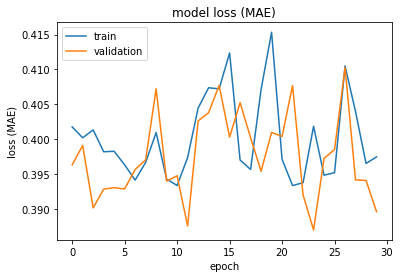

In [52]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss (MAE)')
plt.ylabel('loss (MAE)')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Comparing model performances

In [53]:
df_pred.head()

,Actual,LR,DT,RF,XGB,NN,LR_Diff,DT_Diff,RF_Diff,XGB_Diff,NN_Diff
0,3649.2498,4152.777059,4177.126769,4362.486917,4636.114258,4980.740723,503.527259,527.876969,713.237117,986.864458,1331.490923
1,1845.5976,1748.367116,1609.727606,1661.258917,1722.172852,1793.184448,-97.230484,-235.869994,-184.338683,-123.424748,-52.413152
2,2675.1844,3111.527183,3277.232870,3152.736701,3145.410400,3089.870361,436.342783,602.048470,477.552301,470.226000,414.685961
3,675.7870,1406.538312,1698.317841,1550.695218,1427.145996,1461.161987,730.751312,1022.530841,874.908218,751.358996,785.374987
4,3755.1120,3074.800687,2780.539010,3026.568030,2896.585693,2871.993896,-680.311313,-974.572990,-728.543970,-858.526307,-883.118104


In [54]:
df_pred.describe()

,Actual,LR,DT,RF,XGB,NN,LR_Diff,DT_Diff,RF_Diff,XGB_Diff,NN_Diff
count,1705.000000,1705.000000,1705.000000,1705.000000,1705.000000,1705.000000,1705.000000,1705.000000,1705.000000,1705.000000,1705.000000
mean,2205.287752,2215.099563,2234.490273,2232.126500,2232.993408,2227.853271,9.811811,29.202521,26.838748,27.706141,22.564280
std,1723.413422,1297.153774,1342.527545,1329.410587,1341.378662,1231.213135,1120.351132,1087.784126,1075.444888,1104.639925,1084.571454
min,33.290000,-1341.861640,125.674018,99.152185,63.563324,69.647552,-7958.658690,-7245.782507,-7136.165117,-8476.703081,-7583.095171
25%,874.861200,1422.587499,1223.858133,1286.458772,1243.536499,1357.741577,-568.115929,-460.207478,-428.912991,-440.187663,-420.083927
50%,1796.328400,2264.628770,2219.920691,2043.532406,2136.619873,2220.257324,90.353612,61.047379,51.880385,76.984206,128.214438
75%,3062.014200,3090.338492,3145.924206,3116.056554,3106.416016,3033.392334,654.206687,552.067093,564.323609,561.872671,564.015479
max,13086.964800,5627.446026,5841.182293,5988.314653,7536.988281,6807.272949,3736.815715,3782.656790,3673.337887,4581.421832,3515.197989


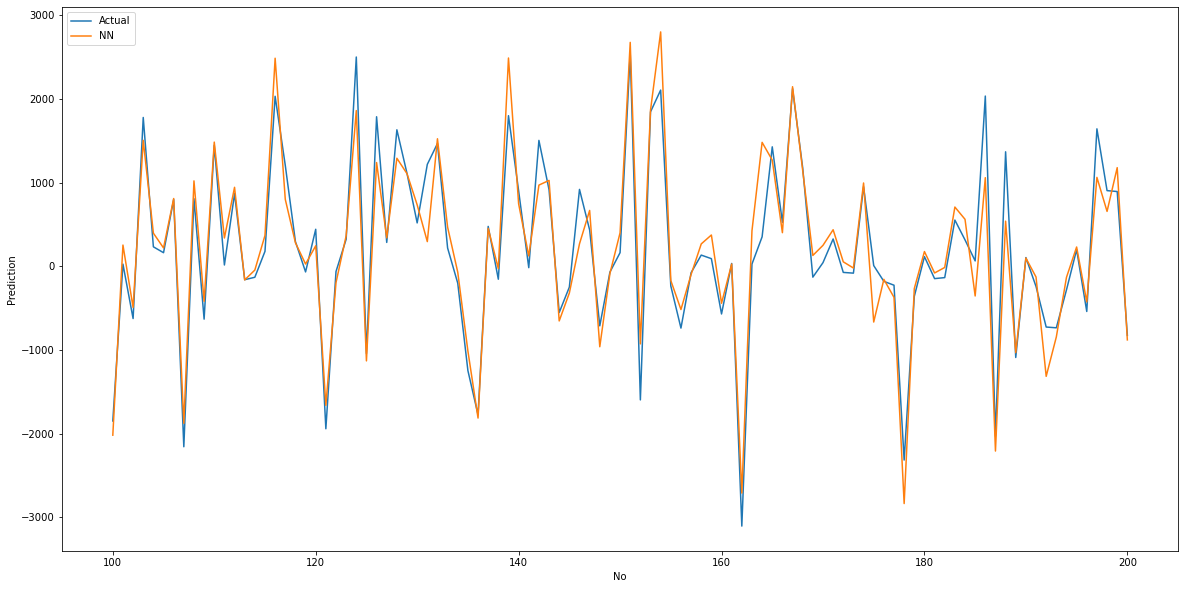

In [55]:
plt.figure(figsize=(20,10))
plt.plot(df_pred.loc[100:200, ['DT_Diff', 'NN_Diff']])
plt.ylabel('Prediction')
plt.xlabel('No')
plt.legend(['Actual', 'NN'], loc='upper left')
plt.show()

## Run selected model

In [56]:
df_test = pd.read_csv('./data/test_preprocessed.csv')

# removing the Item_Identifier and Outlet_Identifier since these are just the unique values
df_test_X = df_test.drop(['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales'], axis = 1)
df_test_X = sc_x.transform(df_test_X)

In [57]:
sel_model_name = 'RF'

sel_model = utils.loadModelFromFile('./model/model_{}.pkl'.format(sel_model_name))

In [58]:
df_test_pred = sel_model.predict(df_test_X)
df_test_pred = sc_y.inverse_transform(df_test_pred)

In [59]:
df_submit = pd.DataFrame({
    'Item_Identifier': df_test['Item_Identifier'],
    'Outlet_Identifier': df_test['Outlet_Identifier'],
    'Item_Outlet_Sales': df_test_pred
})

In [60]:
df_submit

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1665.141912
1,FDW14,OUT017,1322.921290
2,NCN55,OUT010,584.688384
3,FDQ58,OUT017,2419.066603
4,FDY38,OUT027,5864.912108
...,...,...,...
5676,FDB58,OUT046,2155.529586
5677,FDD47,OUT018,2666.935751
5678,NCO17,OUT045,1971.914028
5679,FDJ26,OUT017,3633.478082


In [71]:
df_submit['Item_Outlet_Sales'].describe()

count    5681.000000
mean     2186.534538
std      1322.257052
min        98.731680
25%      1164.739773
50%      2033.908262
75%      3090.710843
max      5973.869186
Name: Item_Outlet_Sales, dtype: float64

In [73]:
df_submit.to_csv('./submission/submit_{}.csv'.format(sel_model_name), index=False)